## EXERCISE 1

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

2024-03-09 18:13:06.644165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 18:13:06.720909: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 18:13:07.103243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 18:13:07.103618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 18:13:07.161789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

1. The lesson discussed two CNN versions: one ending with a global max pooling layer (G), and one
ending with a dense layer (D).
Choose one of the two G and D versions for the remaining exercise, motivating your choice.

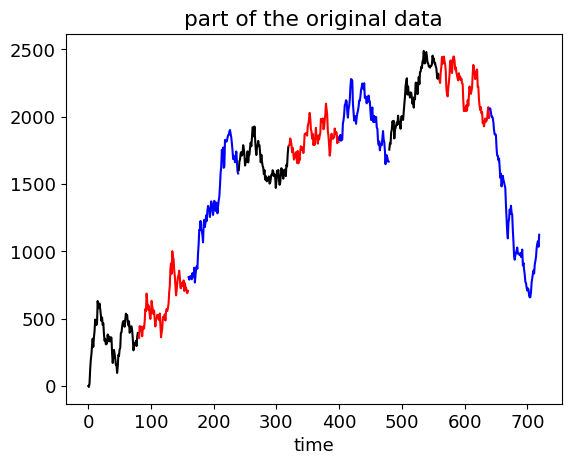

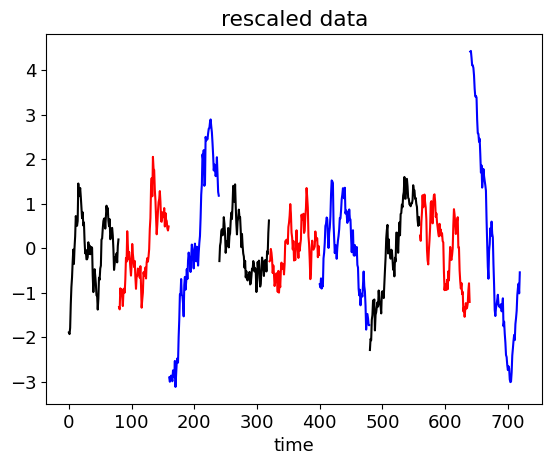

N_train= 3200   N_val= 800   L= 80   n_class= 3
----- Model 2 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 5)             60        
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 5)             105       
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 5)             105       
                                                                 
 global_max_pooling1d (Glob  (None, 5)                 0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 3)                

In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
#print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)
NCONV=2 #change this for see the result of the different model


def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=5, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    #opt = keras.optimizers.Adam()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    #model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

#### Answer:
After testing both models, the choice of the best version of the CNN fell on the global max pooling layer (G). In fact, this model has significantly fewer parameters (228 vs. 1416 in the dense layer (D)) and this reduces computational costs (1.12 KB used vs. 5.53 KB). Also comparing the accuracies in the epochs vs. accuracies graph, we notice in the dense layer a split between the training set and validation set data as the epoch increases making us realize that there is overfitting. This is not the case for the pooling layer, however, so a simpler model is a better fit for our data.

2. Try different optimizers, including at least Adam, RMSprop, and Nesterov. Each one should be
tested for at least five values of the learning rate η (for example, including 10 $^{-5}$, 10 $^{-4}$, 10 $^{-3}$). The
range could be different for different algorithms. Moreover, at least five fits per model should be collected to obtain statistics with an average and standard deviation of the model’s validation accuracy. Plot all results in a single panel of a figure as a function of η.

In [3]:
#def build_model(NF=5,KS=6, NF2=5,KS2=4, lamb=0):
#    """
#    filter = kernel
#    NCONV=index of the CNN architecture
#    NF=nr of filters in the 1st layer
#    KS=kernel size in the 1st layer
#    NF2=nr of filters in the 2nd layer
#    KS2=kernel size in the 2nd layer
#    lamb=not the animal, but lambda, the regularization parameter
#    """
#    reg = keras.regularizers.l2(lamb)
#    model = Sequential()
#
#    model.add(Conv1D(filters=NF, 
#                    kernel_size=KS,
#                    kernel_regularizer=reg,
#                    activation='relu', 
#                    input_shape=input_shape))
#    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
#    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
#    model.add(tf.keras.layers.GlobalMaxPooling1D())
#    model.add(Flatten())
#        
#    model.add(Dense(n_class, activation='softmax'))
#    return model
#
#model =  build_model(KS=11)

In [4]:
optimizers = [keras.optimizers.Adam, keras.optimizers.RMSprop, keras.optimizers.SGD]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
BATCH_SIZE = 200
EPOCHS = 300
results = []

for optimizer in optimizers:
    optimizer_name = optimizer.__name__
    mean_val_accuracies_optimizer = []
    std_val_accuracies_optimizer = []

    for learning_rate in learning_rates:
        opt = optimizer(learning_rate=learning_rate)
        model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

        # Training the model
        fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, shuffle=True)
        val_accuracies = fit.history['val_accuracy']

        mean_val_accuracy_lr = np.mean(val_accuracies)
        std_val_accuracy_lr = np.std(val_accuracies)

        mean_val_accuracies_optimizer.append(mean_val_accuracy_lr)
        std_val_accuracies_optimizer.append(std_val_accuracy_lr)

    results.append({
        'optimizer': optimizer_name,
        'learning_rates': learning_rates,
        'mean_val_accuracy': mean_val_accuracies_optimizer,
        'std_val_accuracy': std_val_accuracies_optimizer
    })
print(results)

[{'optimizer': 'Adam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.36615000188350677, 0.6229708341757456, 0.7568291687965393, 0.7721583302815755, 0.7333083324631056], 'std_val_accuracy': [0.025656591997985655, 0.06173331342256592, 0.01751050106300512, 0.008876343213775707, 0.10244781456614446]}, {'optimizer': 'RMSprop', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.7906083393096924, 0.7913708380858103, 0.7950625020265579, 0.7834166691700617, 0.7027333325147629], 'std_val_accuracy': [0.0031481974994622395, 0.001475838325110948, 0.0022572200717791467, 0.005508836054435573, 0.04618731901330107]}, {'optimizer': 'SGD', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.7358749904235204, 0.7413416588306427, 0.7499416637420654, 0.7604375070333481, 0.7693624959389369], 'std_val_accuracy': [0.0008068665134530628, 0.004439627429951558, 0.0013136955555690959, 0.0030841033450736397, 0.007066262607416083]}]


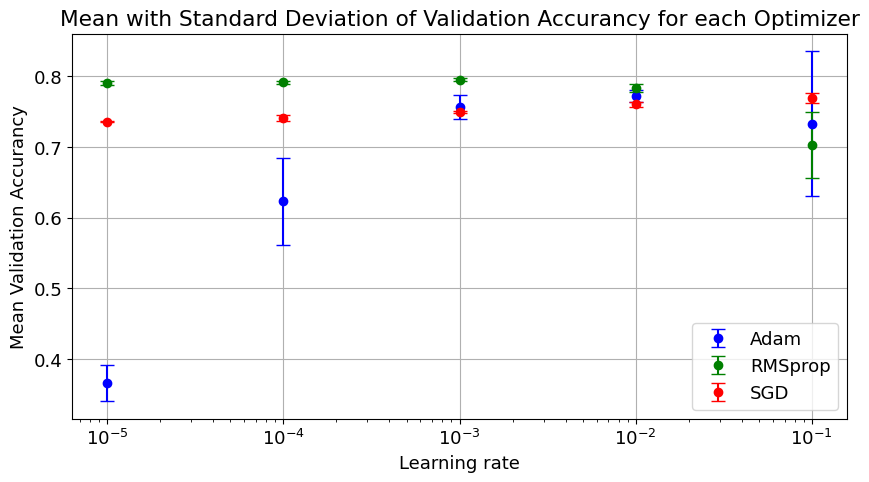

In [5]:
colors = ['blue', 'green', 'red']

plt.figure(figsize=(10, 5))

for i, result in enumerate(results):
    optimizer_name = result['optimizer']
    learning_rates = result['learning_rates']
    mean_val_accuracy = result['mean_val_accuracy']
    std_val_accuracy = result['std_val_accuracy']
    color = colors[i]
    
    
    plt.errorbar(learning_rates, mean_val_accuracy, yerr=std_val_accuracy, fmt='o', capsize=5,label=optimizer_name, color=color)


plt.title('Mean with Standard Deviation of Validation Accurancy for each Optimizer')
plt.xlabel('Learning rate')
plt.ylabel('Mean Validation Accurancy')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

3. Choose one among the best CNNs in step 2 (there could be equivalent ones within error bars).
Using that CNN, try to understand the hidden patterns. Introduce regularization and study the
kernels of the first layer, also by varying their length and their number (respectively, KS and NF in
the notebook). Report your findings, including eventually improved validation accuracy, thanks to
the regularization. However, note that this point’s scope differs from optimizing the validation
accuracy: it focuses on interpreting the kernel shapes.

From the previous graph we can see that one of the best optimizer for the CNN model we are using is Adam with learning rate 0.001, so we'll use this optimizer for the following models.

In [19]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()

In [20]:
def build_model(NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    model.add(Conv1D(filters=NF, 
                    kernel_size=KS,
                    kernel_regularizer=reg,
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
        
    model.add(Dense(n_class, activation='softmax'))
    return model

model =  build_model(KS=11)

In [21]:
best_lr = 10e-3
opt = tf.keras.optimizers.legacy.Adam(learning_rate=best_lr)

lambda_values = [0, 10e-3, 10e-4, 10e-5]
KS_values = [10, 11, 12]
NF_values = [7, 10, 13]
reg_types = [tf.keras.regularizers.l2, tf.keras.regularizers.l1]

accuracies = []

for reg in reg_types:
    for NF in NF_values:
        for KS in KS_values:
            for lamb in lambda_values:
                model = build_model(KS=KS, NF=NF)

                reg1 = reg(0.5)
                model.layers[0].kernel_regularizer = reg1
                model.layers[1].kernel_regularizer = reg1
                model.layers[2].kernel_regularizer = reg1

                model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

                fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, shuffle=True) 

                accuracy = np.mean(fit.history['val_accuracy'])
                accuracies.append({
                    'reg': reg,
                    'NF': NF,
                    'KS': KS,
                    'lambda': lamb,
                    'mean_acc': accuracy
                })


max_accuracy = max(acc['mean_acc'] for acc in accuracies)

print(max_accuracy)

0.7766125001509985


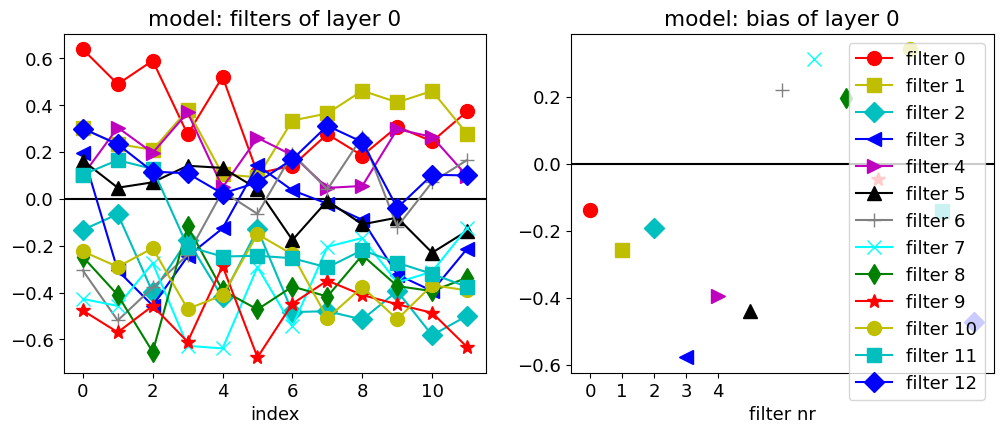

Best reg = [<class 'keras.src.regularizers.L1'>]
Best NF = [7]
Best KS = [11]
Best lambda = [0]


In [25]:
# studiare il kernel del primo layer
model = build_model(KS=KS, NF=NF)

best_reg = [acc['reg'] for acc in accuracies if acc['mean_acc'] == max_accuracy]
best_NF = [acc['NF'] for acc in accuracies if acc['mean_acc'] == max_accuracy]
best_KS = [acc['KS'] for acc in accuracies if acc['mean_acc'] == max_accuracy]
best_lambda = [acc['lambda'] for acc in accuracies if acc['mean_acc'] == max_accuracy]


reg1 = best_reg[0](0.5)

model.layers[0].kernel_regularizer = reg1
model.layers[1].kernel_regularizer = reg1
model.layers[2].kernel_regularizer = reg1

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, shuffle=True)

Show_weights(model, 0)

print(f"Best reg = {best_reg}")
print(f"Best NF = {best_NF}")
print(f"Best KS = {best_KS}")
print(f"Best lambda = {best_lambda}")

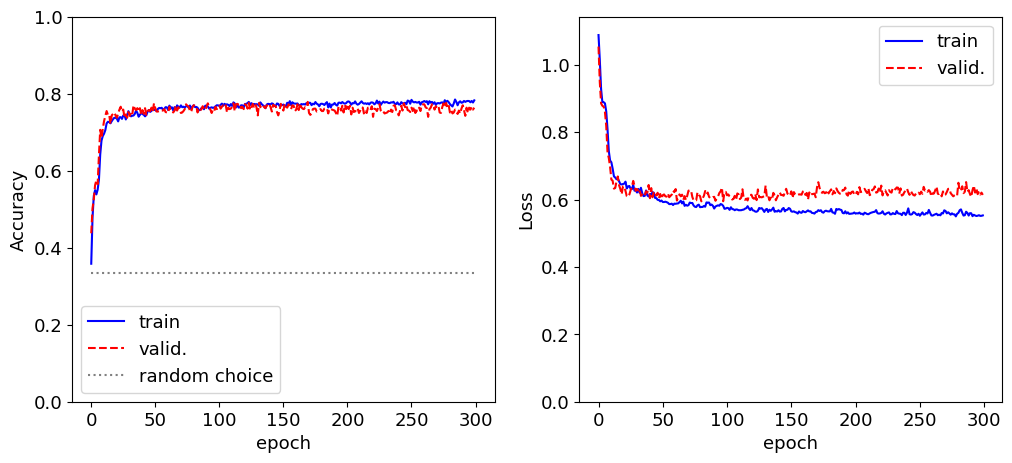

In [23]:
# it allows us to observe how the validation accuracy varies
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

Show_history(fit)

25/25 [==============================] - 0s 5ms/step


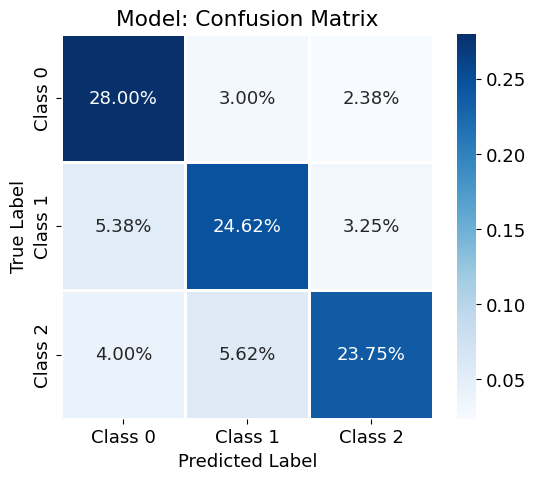

In [24]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

The show_weights() function allows us to observe the hidden patters of our neural network and in particular the value of the weights of our filters/kernels. In fact it is these weights that are multiplied by element to the input data and the sum of all results in a single output pixel, so observing the shape of the various filters allows us to know the individual steps that our network is performing. Weights with higher values indicate greater importance for that particular pixel or feature of the input, while values close to zero indicate less importance. Positive weights may indicate the presence of specific features or patterns in the input, while negative weights may indicate the lack or absence of such features. Of course, a constant term must be added to all this, namely the bias associated with the filters, which is added to the weighted sum of the input and the weights, affecting the sensitivity of the filter.

We also introduced regularization to see how our kernel changes, and in particular we used regularization with LASSO and RIDGE. 
By changing the parameters we observed that the best parameters are LASSO as best regularizer, 7 as best NF, 11 as best KS, 0 as best lambda.
We note in general that the Adam optimizer fits our data well, in fact in the validation accuracy plot both training and validation data follow the same curve. 

Finally we displayed the confusion matrix in which it is possible to see that the classification of the 3 classes is well predicted.